## Initial Setup

In [ ]:
# Create a function that returns the required local i.e. UTF-8

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# Installing Libraries that we will use
# Disclaimer: Package updates may causes inconsistency, downgrade packages which causes inconsistency issues.
!pip install praw
!pip install pyLDAvis==3.4.0
!pip install bertopic
!pip install umap-learn
!pip install hdbscan
!pip install flair
!pip install pyspellchecker
!pip install protobuf==4.22.1
!apt-get -qq install -y libfluidsynth1
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.2
    Uninstalling protobuf-3.20.2:
      Succe

In [ ]:
import os
import re
import time
from collections import Counter
from string import punctuation

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import praw
import warnings

import gensim
import gensim.corpora as corpora
import gensim.models.phrases as phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

import nltk
from nltk.corpus import stopwords, words
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy

from spellchecker import SpellChecker

from bertopic import BERTopic

nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Extracting Data from Reddit

Disclaimer: Data request can take upto 10 minutes.

In [ ]:
# Getting Data directly from Reddit through API

warnings.filterwarnings("ignore", message=".*It appears that you are using PRAW in an asynchronous environment.*", category=UserWarning)

reddit = praw.Reddit(client_id='', client_secret='', user_agent='NLP Task 2 by u/')

# Define the keywords and subreddits to search in
keywords = ['mould', 'black mould'] #Keywords based data extraction
subreddits = ['AskUK', 'unitedkingdom', 'Landlord', 'CasualUK', 'mold', 'CleaningTips', 'HomeImprovement'] #Data from these subreddits

# Define the number of posts to retrieve
num_posts = 1200

# Define a list to store the extracted data
data = []

# Loop through each subreddit
for subreddit in subreddits:
    # Use pagination to retrieve the posts in batches of 100
    for i in range(0, num_posts, 100):
        # Use the PRAW API to search for posts containing the keywords
        search_results = reddit.subreddit(subreddit).search(f"{' OR '.join(keywords)}", limit=100, params={'after': i})
        # Process the search results
        for result in search_results:
            # Check if the post has a non-empty selftext field
            if result.selftext:
                # Extract the relevant data from each post
                post_title = result.title
                post_text = result.selftext
                post_author = result.author.name
                post_created_utc = result.created_utc
                # Store the data in the list
                data.append({'title': post_title, 'text': post_text, 'author': post_author, 'created_utc': post_created_utc})
        # Delay for 4 seconds before making the next request
        time.sleep(4)

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)
df

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

KeyboardInterrupt: ignored

In [ ]:
# Saving as CSV file to review and later use

df.to_csv('data.csv', index=False, encoding='utf-8-sig')

## Loading the dataset

In [ ]:
# Extracted data from csv file (From Reddit API) and creatinga a pandas DataFrame

df = pd.read_csv('/content/data.csv', encoding='utf-8')
df.head(10)

,title,text,author,created_utc
0,Are those mould remover sprays much better tha...,I did some extensive Google on how to remove b...,eatqqq,1.669649e+09
1,Anyone tried custom earplugs moulded by Boots ...,"Hi all,\n\nI'm sensitive to noise when sleepin...",bid00f__,1.681279e+09
2,what are some good tips to deal with condensat...,"Every day in winter we need to open windows, o...",Garrett8319,1.678179e+09
3,how should I clean a painted wall to get rid o...,I have already tried bleach and vinegar but th...,QueenLunaEatingTuna,1.678731e+09
4,How do you know if you have mould in your house?,Little backstory. We moved to our current home...,Fair_Department_4943,1.670403e+09
5,Any tips for avoiding excessive mould or fungu...,We are going on holiday for around a month and...,Massive_Brush1279,1.674827e+09
6,Has anyone had any first hand experience with ...,My partner and I have been feeling sort of non...,mary4twenty,1.632909e+09
7,How to get my landlord to fix the mould in my ...,I’ve asked landlord over 4 months now to fix t...,Acceptable-Kick-4201,1.674908e+09
8,Does anyone know why our view of mould/mildew ...,Every time I see mention of mould/mildew (or ...,pinksparklebird,1.646938e+09
9,Is there anything I can put in a fridge when i...,We’re coming to the end of a fixed-rate tariff...,je_m_appelle_,1.661703e+09


In [ ]:
# Info about the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        16280 non-null  object 
 1   text         16280 non-null  object 
 2   author       16280 non-null  object 
 3   created_utc  16280 non-null  float64
dtypes: float64(1), object(3)
memory usage: 508.9+ KB


## Pre-processing the data

In [ ]:
# Cleaning the text data

# Create a set of English words
english_words = set(words.words())

# Load the Spacy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def clean_text(text):
    # Replacing all 'mold' words with 'mould'
    text = re.sub(r'\bmold\b', 'mould', text)

    # Discard data that doesn't contain basic targeted keyword
    if not re.search(r'mould', text, re.IGNORECASE):
         return ''

    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]+', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Removing emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Convert to lowercase
    text = text.lower()

    # Tokenize text
    words = word_tokenize(text)

    # # # Count word frequencies
    # word_counts = Counter(words)

    # # Remove rare words
    # words = [word for word in words if word_counts[word] <= 10]

    # Remove misspelled/miswritten words
    # spell = SpellChecker()
    # words = text.split()
    # words = [spell.correction(word) for word in words if spell.correction(word) is not None]


    # Remove words not in English dictionary
    words = [word for word in words if word in english_words]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    custom_stopwords = ['one', 'im', 'dont know', 'time', 'im', 'dont know', 'time','thing', 'tell', 'xb', 'x b', 'x', 'b' 'think', 'try', 'ive','kid', 'know', 'way',
                    'people', 'going', 'director', 'defence', 'director', 'game director', 'sheer', 'grit', 'turned yesterday', 'amp', 'yes', 'ca', 'qrt',
                    'vm', 'u', 'say', 'nice', 'thank', 'advance', 'need', 'also', 'like', 'back', 'get', 'make sure', 'last year', 'would', 'could',
                    'washing machine', 'washing', 'machine', 'piece b', 'make sure', 'hi', 'everyone', 'year old', 'year', 'last year', 'day ago',
                    'mould  mould', 'thanks', 'anyone', 'make', 'sure', 'keep', 'couple', 'top', 'please help', 'get', 'go', 'say', 'find', 'come']
    stop_words.update(custom_stopwords)
    words = [word for word in words if word not in stop_words]

    # Apply stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Lemmatize words and filter by part of speech
    lemmatized_words = []
    doc = nlp(' '.join(words))
    for token in doc:
        if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']:
            lemmatized_words.append(token.lemma_)

    # Join words back into a string
    cleaned_text = ' '.join(lemmatized_words)

    return cleaned_text

df['text'] = df['title'] + ' ' + df['text']
df = df.drop(columns=['title', 'author', 'created_utc'])
df['Clean text'] = df['text'].apply(clean_text)

# Dropping rows with null data
df.dropna(subset=['Clean text'], inplace=True)
df = df[df['Clean text'].str.strip().astype(bool)]
df = df.reset_index(drop=True)  # Reset the index

# Viewing the data
df.head(10)

,text,Clean text
0,How can I help clean up mould? Sub contract wo...,help clean mould sub contract work house spot ...
1,Are those mould remover sprays much better tha...,remover much well vinegar bleach extensive rem...
2,Anyone tried custom earplugs moulded by Boots ...,try custom mould boot sleep sensitive noise sl...
3,what are some good tips to deal with condensat...,good deal condensation mould home work day win...
4,how should I clean a painted wall to get rid o...,clean paint wall rid mould paint already try b...
5,How do you know if you have mould in your hous...,house little current home june house recently ...
6,Has anyone had any first hand experience with ...,first hand experience black mould poison partn...
7,Any tips for avoiding excessive mould or fungu...,excessive mould fungus house leave uninhabited...
8,How to get my landlord to fix the mould in my ...,landlord fix mould flat landlord fix grow bedr...
9,Does anyone know why our view of mould/mildew ...,view mould mildew vastly brother see mention m...


In [ ]:
# Words Frequency of most common terms

words_list = []
for sentence in df['Clean text']:
    words_list.extend(nltk.word_tokenize(sentence))
freq_dist = nltk.FreqDist(words_list)
freq_dist.most_common(20)


[('mould', 8244),
 ('house', 2580),
 ('room', 2184),
 ('wall', 1812),
 ('black', 1740),
 ('get', 1728),
 ('paint', 1644),
 ('clean', 1632),
 ('landlord', 1548),
 ('bathroom', 1512),
 ('damp', 1476),
 ('think', 1428),
 ('use', 1404),
 ('water', 1368),
 ('leave', 1344),
 ('live', 1308),
 ('see', 1296),
 ('help', 1200),
 ('work', 1200),
 ('really', 1200)]

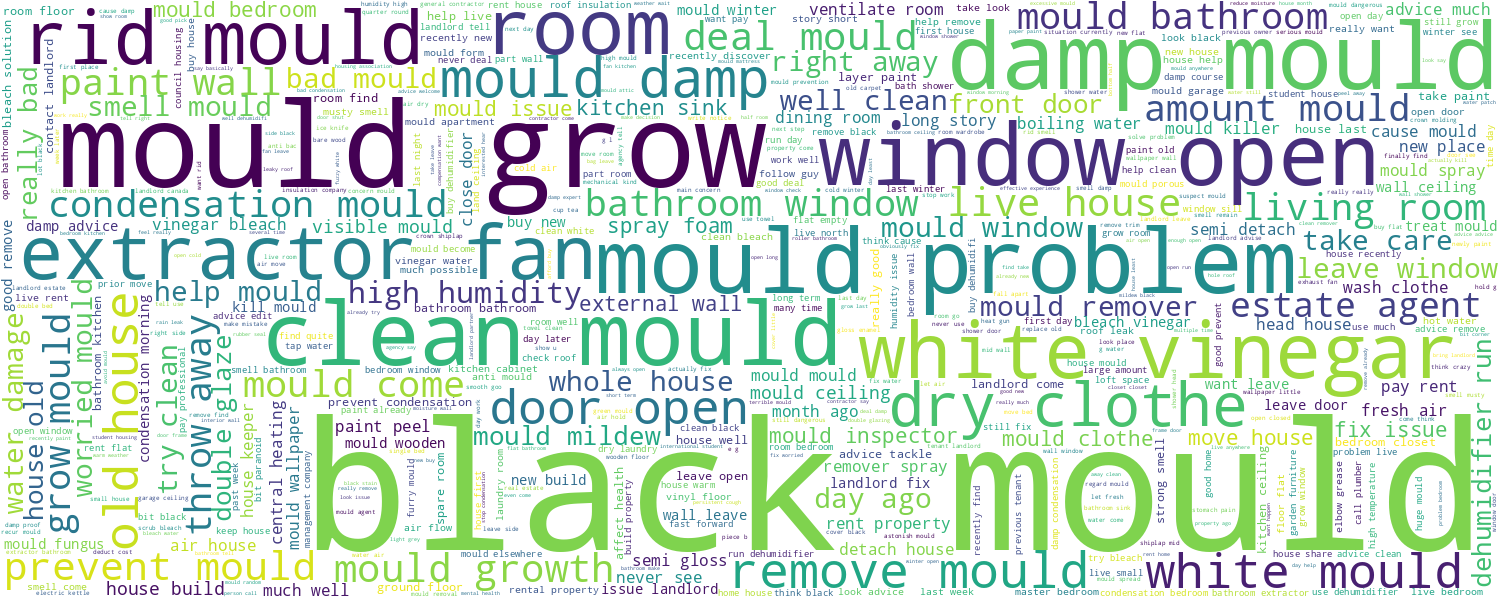

In [ ]:
# Generating the WordCloud

# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['Clean text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", height=600, width=1500, max_words=500, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## LDA Implemenation

In [ ]:
# Creating n-grams

def create_ngrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

# Create bigrams and trigrams
df['unigrams'] = df['Clean text'].apply(lambda x: x.split())
df['bigrams'] = df['unigrams'].apply(lambda x: create_ngrams(x, 2))
df['trigrams'] = df['unigrams'].apply(lambda x: create_ngrams(x, 3))
df.head(10)

,text,Clean text,unigrams,bigrams,trigrams
0,How can I help clean up mould? Sub contract wo...,help clean mould sub contract work house spot ...,"[help, clean, mould, sub, contract, work, hous...","[help clean, clean mould, mould sub, sub contr...","[help clean mould, clean mould sub, mould sub ..."
1,Are those mould remover sprays much better tha...,remover much well vinegar bleach extensive rem...,"[remover, much, well, vinegar, bleach, extensi...","[remover much, much well, well vinegar, vinega...","[remover much well, much well vinegar, well vi..."
2,Anyone tried custom earplugs moulded by Boots ...,try custom mould boot sleep sensitive noise sl...,"[try, custom, mould, boot, sleep, sensitive, n...","[try custom, custom mould, mould boot, boot sl...","[try custom mould, custom mould boot, mould bo..."
3,what are some good tips to deal with condensat...,good deal condensation mould home work day win...,"[good, deal, condensation, mould, home, work, ...","[good deal, deal condensation, condensation mo...","[good deal condensation, deal condensation mou..."
4,how should I clean a painted wall to get rid o...,clean paint wall rid mould paint already try b...,"[clean, paint, wall, rid, mould, paint, alread...","[clean paint, paint wall, wall rid, rid mould,...","[clean paint wall, paint wall rid, wall rid mo..."
5,How do you know if you have mould in your hous...,house little current home june house recently ...,"[house, little, current, home, june, house, re...","[house little, little current, current home, h...","[house little current, little current home, cu..."
6,Has anyone had any first hand experience with ...,first hand experience black mould poison partn...,"[first, hand, experience, black, mould, poison...","[first hand, hand experience, experience black...","[first hand experience, hand experience black,..."
7,Any tips for avoiding excessive mould or fungu...,excessive mould fungus house leave uninhabited...,"[excessive, mould, fungus, house, leave, uninh...","[excessive mould, mould fungus, fungus house, ...","[excessive mould fungus, mould fungus house, f..."
8,How to get my landlord to fix the mould in my ...,landlord fix mould flat landlord fix grow bedr...,"[landlord, fix, mould, flat, landlord, fix, gr...","[landlord fix, fix mould, mould flat, flat lan...","[landlord fix mould, fix mould flat, mould fla..."
9,Does anyone know why our view of mould/mildew ...,view mould mildew vastly brother see mention m...,"[view, mould, mildew, vastly, brother, see, me...","[view mould, mould mildew, mildew vastly, vast...","[view mould mildew, mould mildew vastly, milde..."


In [ ]:
# Unigrams

# Create a dictionary for the unigrams
dictionary_unigrams = Dictionary(df['unigrams'])
# Create a corpus for the tokens
corpus_unigrams = [dictionary_unigrams.doc2bow(text) for text in df['unigrams']]

num_topics = 4

# Tokens Model
unigrams_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_unigrams,
                                                   id2word=dictionary_unigrams,
                                                   random_state=100,
                                                   update_every=1,
                                                   passes=15,
                                                   chunksize=100,
                                                   alpha=0.001,
                                                   eta='auto',
                                                   num_topics=num_topics,
                                                   per_word_topics=True)

# Visualize the topics
pyLDAvis.enable_notebook()

unigrams_vis = pyLDAvis.gensim_models.prepare(unigrams_lda_model, corpus_unigrams, dictionary_unigrams)

# Display the tokens visualization
pyLDAvis.display(unigrams_vis)

In [ ]:
# Bigram token model training and visualization

# Create a dictionary for the bigrams
bigram_dictionary = corpora.Dictionary(df['bigrams'])
# Create a corpus for the bigrams
bigram_corpus = [bigram_dictionary.doc2bow(text) for text in df['bigrams']]

num_topics = 3

# Bigram Model
bigram_lda_model = gensim.models.ldamodel.LdaModel(corpus=bigram_corpus,
                                                   id2word=bigram_dictionary,
                                                   random_state=111,
                                                   update_every=1,
                                                   passes=15,
                                                   chunksize=100,
                                                   alpha=0.003,
                                                   eta='auto',
                                                   num_topics=num_topics,
                                                   per_word_topics=True)

bigram_vis = pyLDAvis.gensim_models.prepare(bigram_lda_model, bigram_corpus, bigram_dictionary)

# Display the visualization
pyLDAvis.display(bigram_vis)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

perplexity = bigram_lda_model.log_perplexity(bigram_corpus)
perplexity = 2**(-perplexity)  # Convert to perplexity score
print("Perplexity Score:", perplexity)

# Compute coherence score
coherence_model_lda = CoherenceModel(model=bigram_lda_model, corpus=bigram_corpus, dictionary=bigram_dictionary, coherence='u_mass')
coherence_score = coherence_model_lda.get_coherence()
print("Coherence Score:", coherence_score)


Perplexity Score: 976.9108282924024
Coherence Score: -13.029061571496905


In [ ]:
# Trigram token model training and visualization

# Create a dictionary for the trigrams
trigram_dictionary = corpora.Dictionary(df['trigrams'])
# Create a corpus for the trigrams
trigram_corpus = [trigram_dictionary.doc2bow(text) for text in df['trigrams']]

num_topics = 4

# Trigram Model
trigram_lda_model = gensim.models.ldamodel.LdaModel(corpus=trigram_corpus,
                                                   id2word=trigram_dictionary,
                                                   random_state=100,
                                                   update_every=1,
                                                   passes=15,
                                                   chunksize=100,
                                                   alpha=0.001,
                                                   eta='auto',
                                                   num_topics=num_topics,
                                                   per_word_topics=True)

trigram_vis = pyLDAvis.gensim_models.prepare(trigram_lda_model, trigram_corpus, trigram_dictionary)

# Display the Trigram visualization
pyLDAvis.display(trigram_vis)

## BERTopic Implementation

In [ ]:
# Topic model
from bertopic import BERTopic

# Dimension reduction
from umap import UMAP

# Clustering
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans

# Count vectorization
from sklearn.feature_extraction.text import CountVectorizer

# Sentence transformer
from sentence_transformers import SentenceTransformer

# Flair
from transformers.pipelines import pipeline
from flair.embeddings import TransformerDocumentEmbeddings, WordEmbeddings, DocumentPoolEmbeddings, StackedEmbeddings

# Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)

# Clustering model
# hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples = 5,
# metric='euclidean', prediction_data=True)

kmeans_model = KMeans(n_clusters=30)
# Initiate a sentence transformer model
sentence_model = SentenceTransformer("paraphrase-albert-small-v2")

# Initiate a pretrained model
hf_model = pipeline("feature-extraction", model="distilroberta-base")

# Initiate a pretrained embedding model
roberta_model = TransformerDocumentEmbeddings('roberta-base')

# Initiate another pretrained embedding model
glove_embedding = WordEmbeddings('crawl')
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])

# Stack the two pretrained embedding models
stacked_embeddings = StackedEmbeddings(embeddings=[roberta_model,
document_glove_embeddings])

# Count vectorizer
vectorizer_model = CountVectorizer(min_df=15)

# Initiate BERTopic
# topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True,hdbscan_model=kmeans_model,
#                        embedding_model=stacked_embeddings,min_topic_size=5, n_gram_range=(1, 3),diversity=0.8, vectorizer_model=vectorizer_model) # Other options for embedding_model are sentence_model, hf_model,roberta_model

# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True, hdbscan_model=kmeans_model,
                       n_gram_range=(1, 2), vectorizer_model=vectorizer_model, min_topic_size=5)
# Run BERTopic model
topics, probabilities = topic_model.fit_transform(df['Clean text'])

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2023-04-28 22:51:59,263 https://flair.informatik.hu-berlin.de/resources/embeddings/token/en-fasttext-crawl-300d-1M.vectors.npy not found in cache, downloading to /tmp/tmpku1l02ea


100%|██████████| 1.12G/1.12G [01:30<00:00, 13.2MB/s]

2023-04-28 22:53:30,536 copying /tmp/tmpku1l02ea to cache at /root/.flair/embeddings/en-fasttext-crawl-300d-1M.vectors.npy


2023-04-28 22:53:34,946 removing temp file /tmp/tmpku1l02ea
2023-04-28 22:53:36,577 https://flair.informatik.hu-berlin.de/resources/embeddings/token/en-fasttext-crawl-300d-1M not found in cache, downloading to /tmp/tmpua9yi5oh


100%|██████████| 37.5M/37.5M [00:04<00:00, 8.92MB/s]

2023-04-28 22:53:41,676 copying /tmp/tmpua9yi5oh to cache at /root/.flair/embeddings/en-fasttext-crawl-300d-1M
2023-04-28 22:53:41,755 removing temp file /tmp/tmpua9yi5oh


In [ ]:
# To update the n-gram range, uncomment the code below

# topic_model.update_topics(df['Clean text'], n_gram_range=(1, 4))

In [ ]:
# Get the list of topics
topic_model.get_topic_info()

,Topic,Count,Name
0,0,624,0_mould_wall_damp_room
1,1,444,1_mould_go_white_rid
2,2,336,2_mould_room_leave_home
3,3,288,3_paint_house_give_get
4,4,276,4_black_remove_advice_mould
5,5,276,5_wall_mould_dehumidifier_good
6,6,192,6_room_damp_deal_much
7,7,180,7_work_first_door_place
8,8,156,8_flat_find_problem_wonder
9,9,144,9_wall_floor_try_look


In [ ]:
# Previewing the top topics

topic_model.visualize_hierarchy(top_n_topics=10)

In [ ]:
# Visualizing all topics

topic_model.visualize_topics()


In [ ]:
# Only selecting our targetted keyword topics

similar_topics, similarity = topic_model.find_topics("mould", top_n=10); similar_topics

topic_model.visualize_topics(similar_topics)


In [ ]:
# Get top 10 terms for a topic
topic_model.get_topic(2)

[('mould', 0.03944373145099869),
 ('room', 0.03602529487845465),
 ('leave', 0.03576367858062239),
 ('home', 0.03260854018093149),
 ('paint', 0.02960773883984446),
 ('use', 0.02830135352628598),
 ('clean', 0.027762418105072937),
 ('open', 0.027582381438406276),
 ('try', 0.0269214182062337),
 ('away', 0.026554699156186173)]

In [ ]:
# Visualize term rank decrease

topic_model.visualize_term_rank()


In [ ]:
# Visualize top topic keywords
topic_model.visualize_barchart(similar_topics, top_n_topics=10)

In [ ]:
# Visualize similarity using heatmap
topic_model.visualize_heatmap(similar_topics)

In [ ]:
# New documents to be predicted

new_docs = ['How to get rid of black mould with bleach']

# Predict topics of new documents using the transform method
new_docs_topics = topic_model.transform(new_docs)

# Print predicted topics of new documents
print(new_docs_topics)


([19], None)


## NMF Implementation


In [ ]:

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

wn = nltk.WordNetLemmatizer()

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = tfidf_vectorizer.fit_transform(df['Clean text'])

Extracting tf-idf features for NMF...


In [ ]:
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(df['Clean text'])

Extracting tf features for LDA...


Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


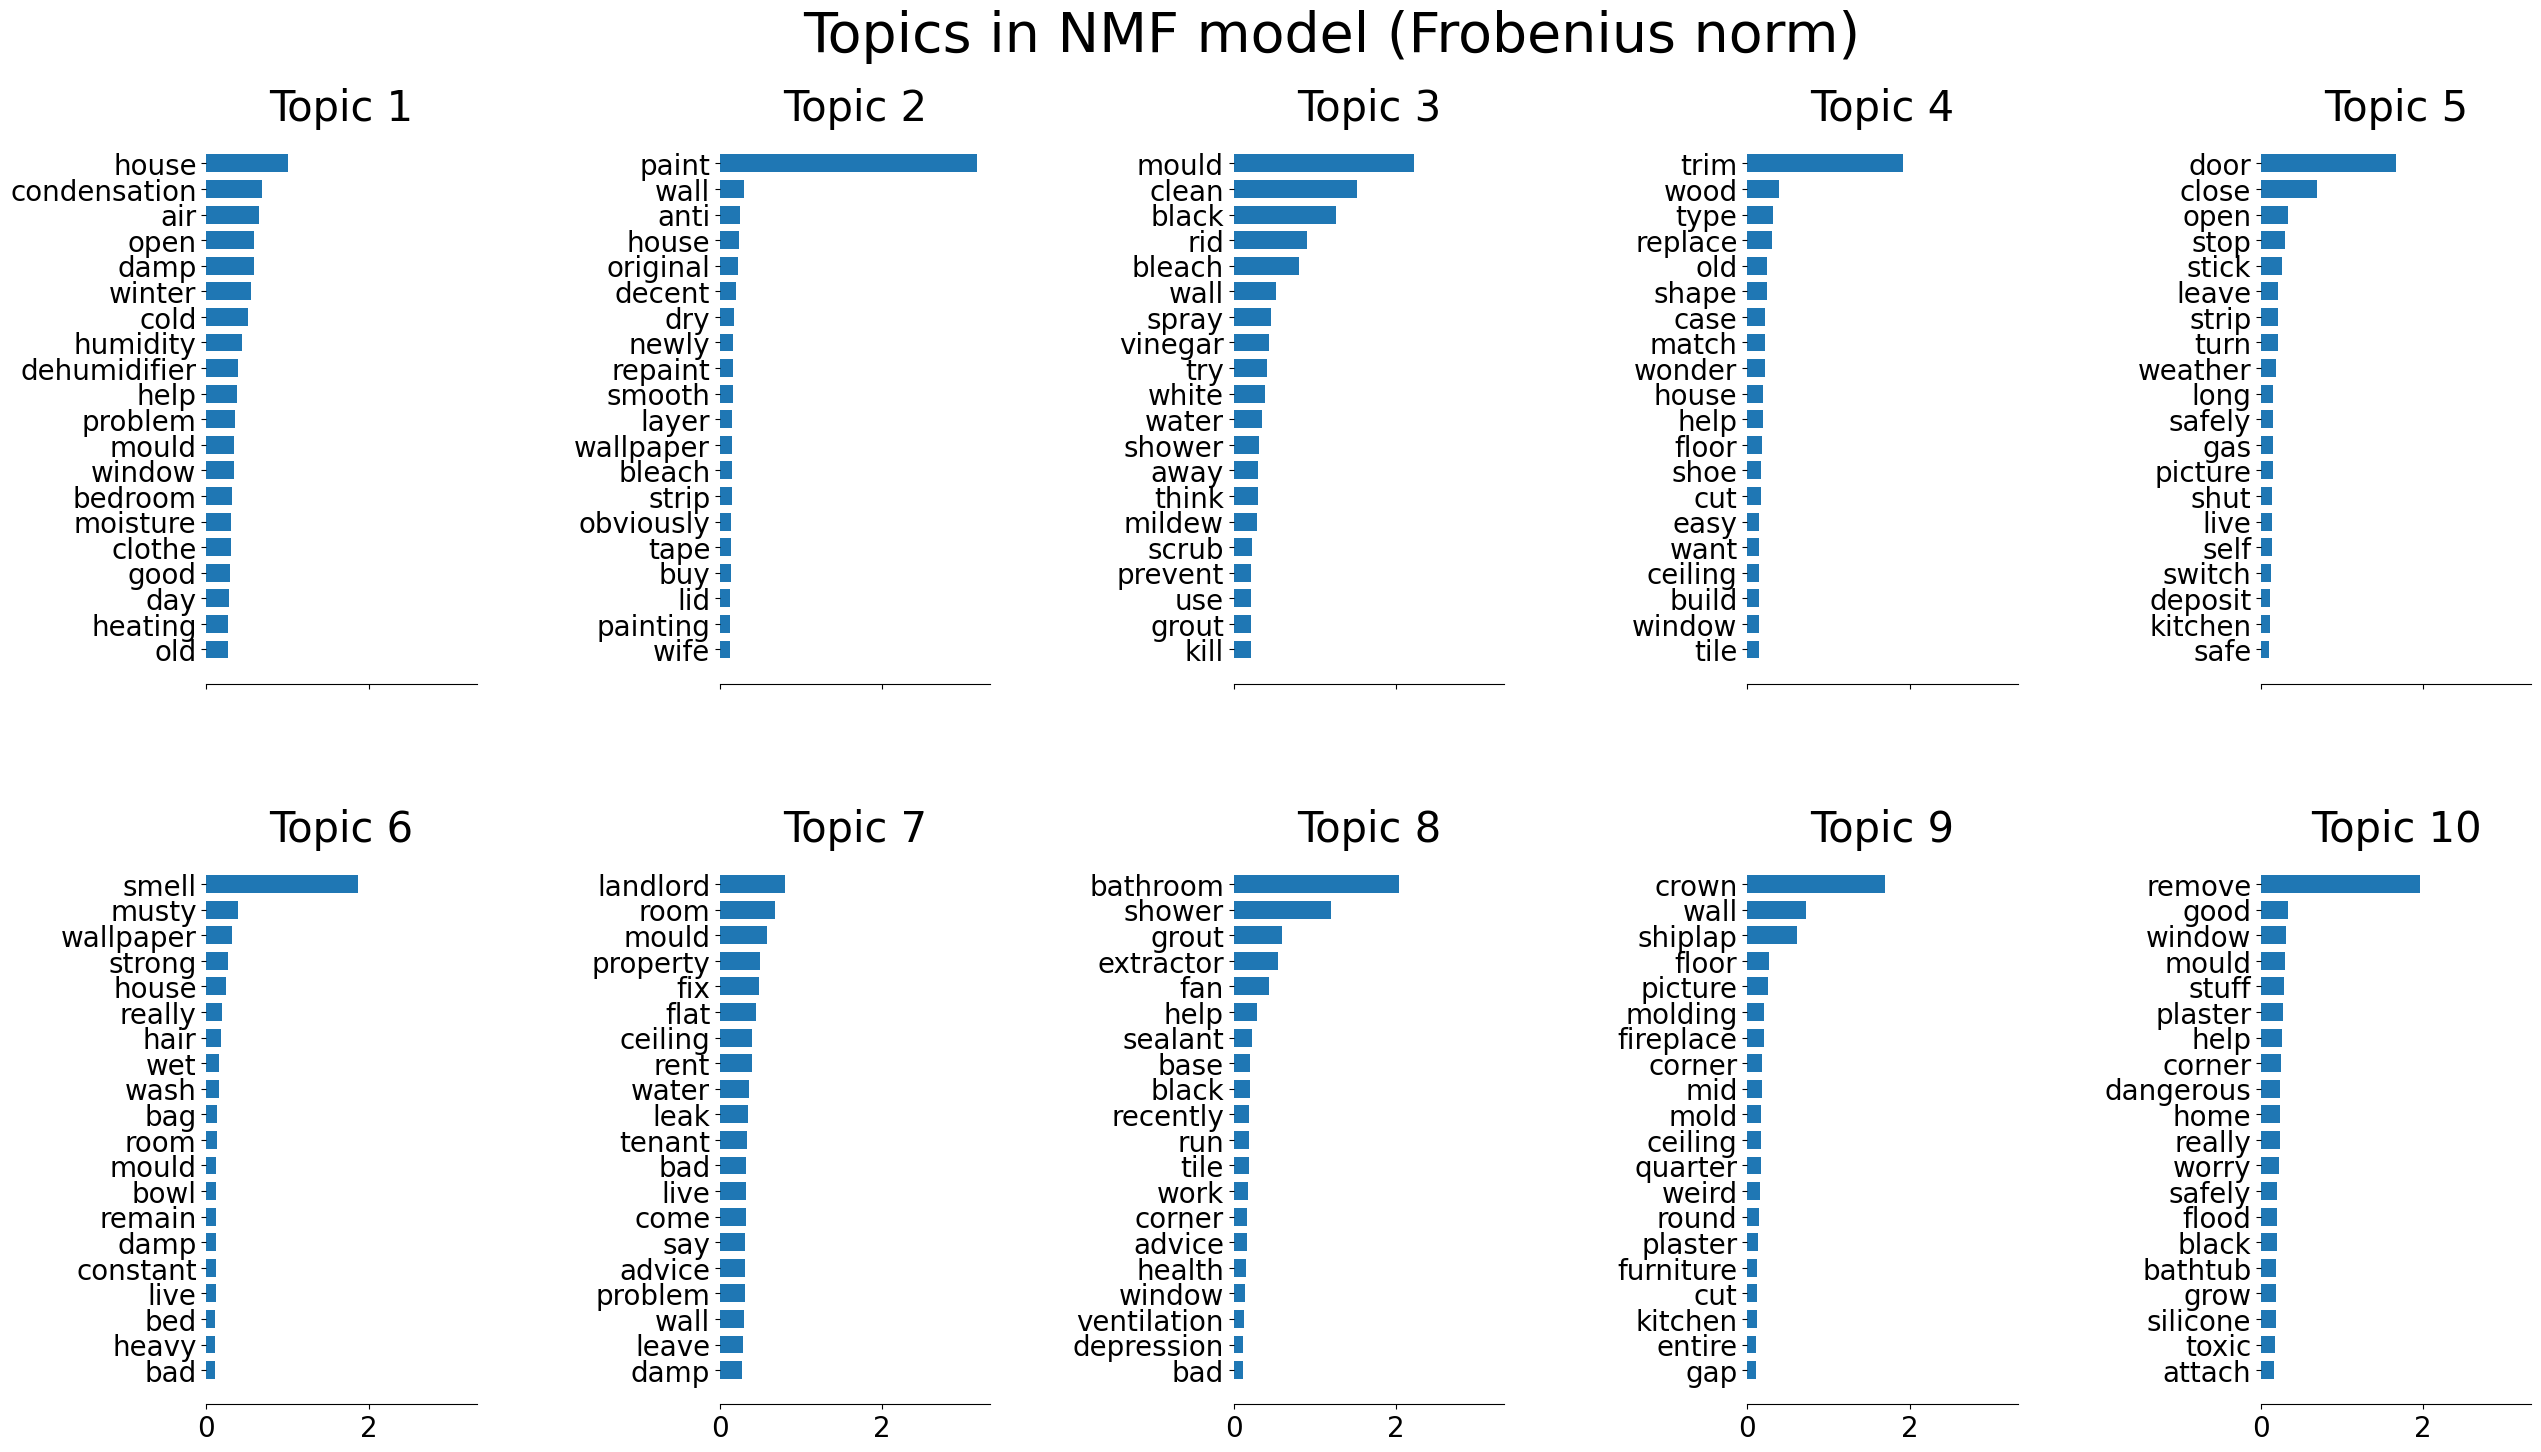

In [ ]:
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


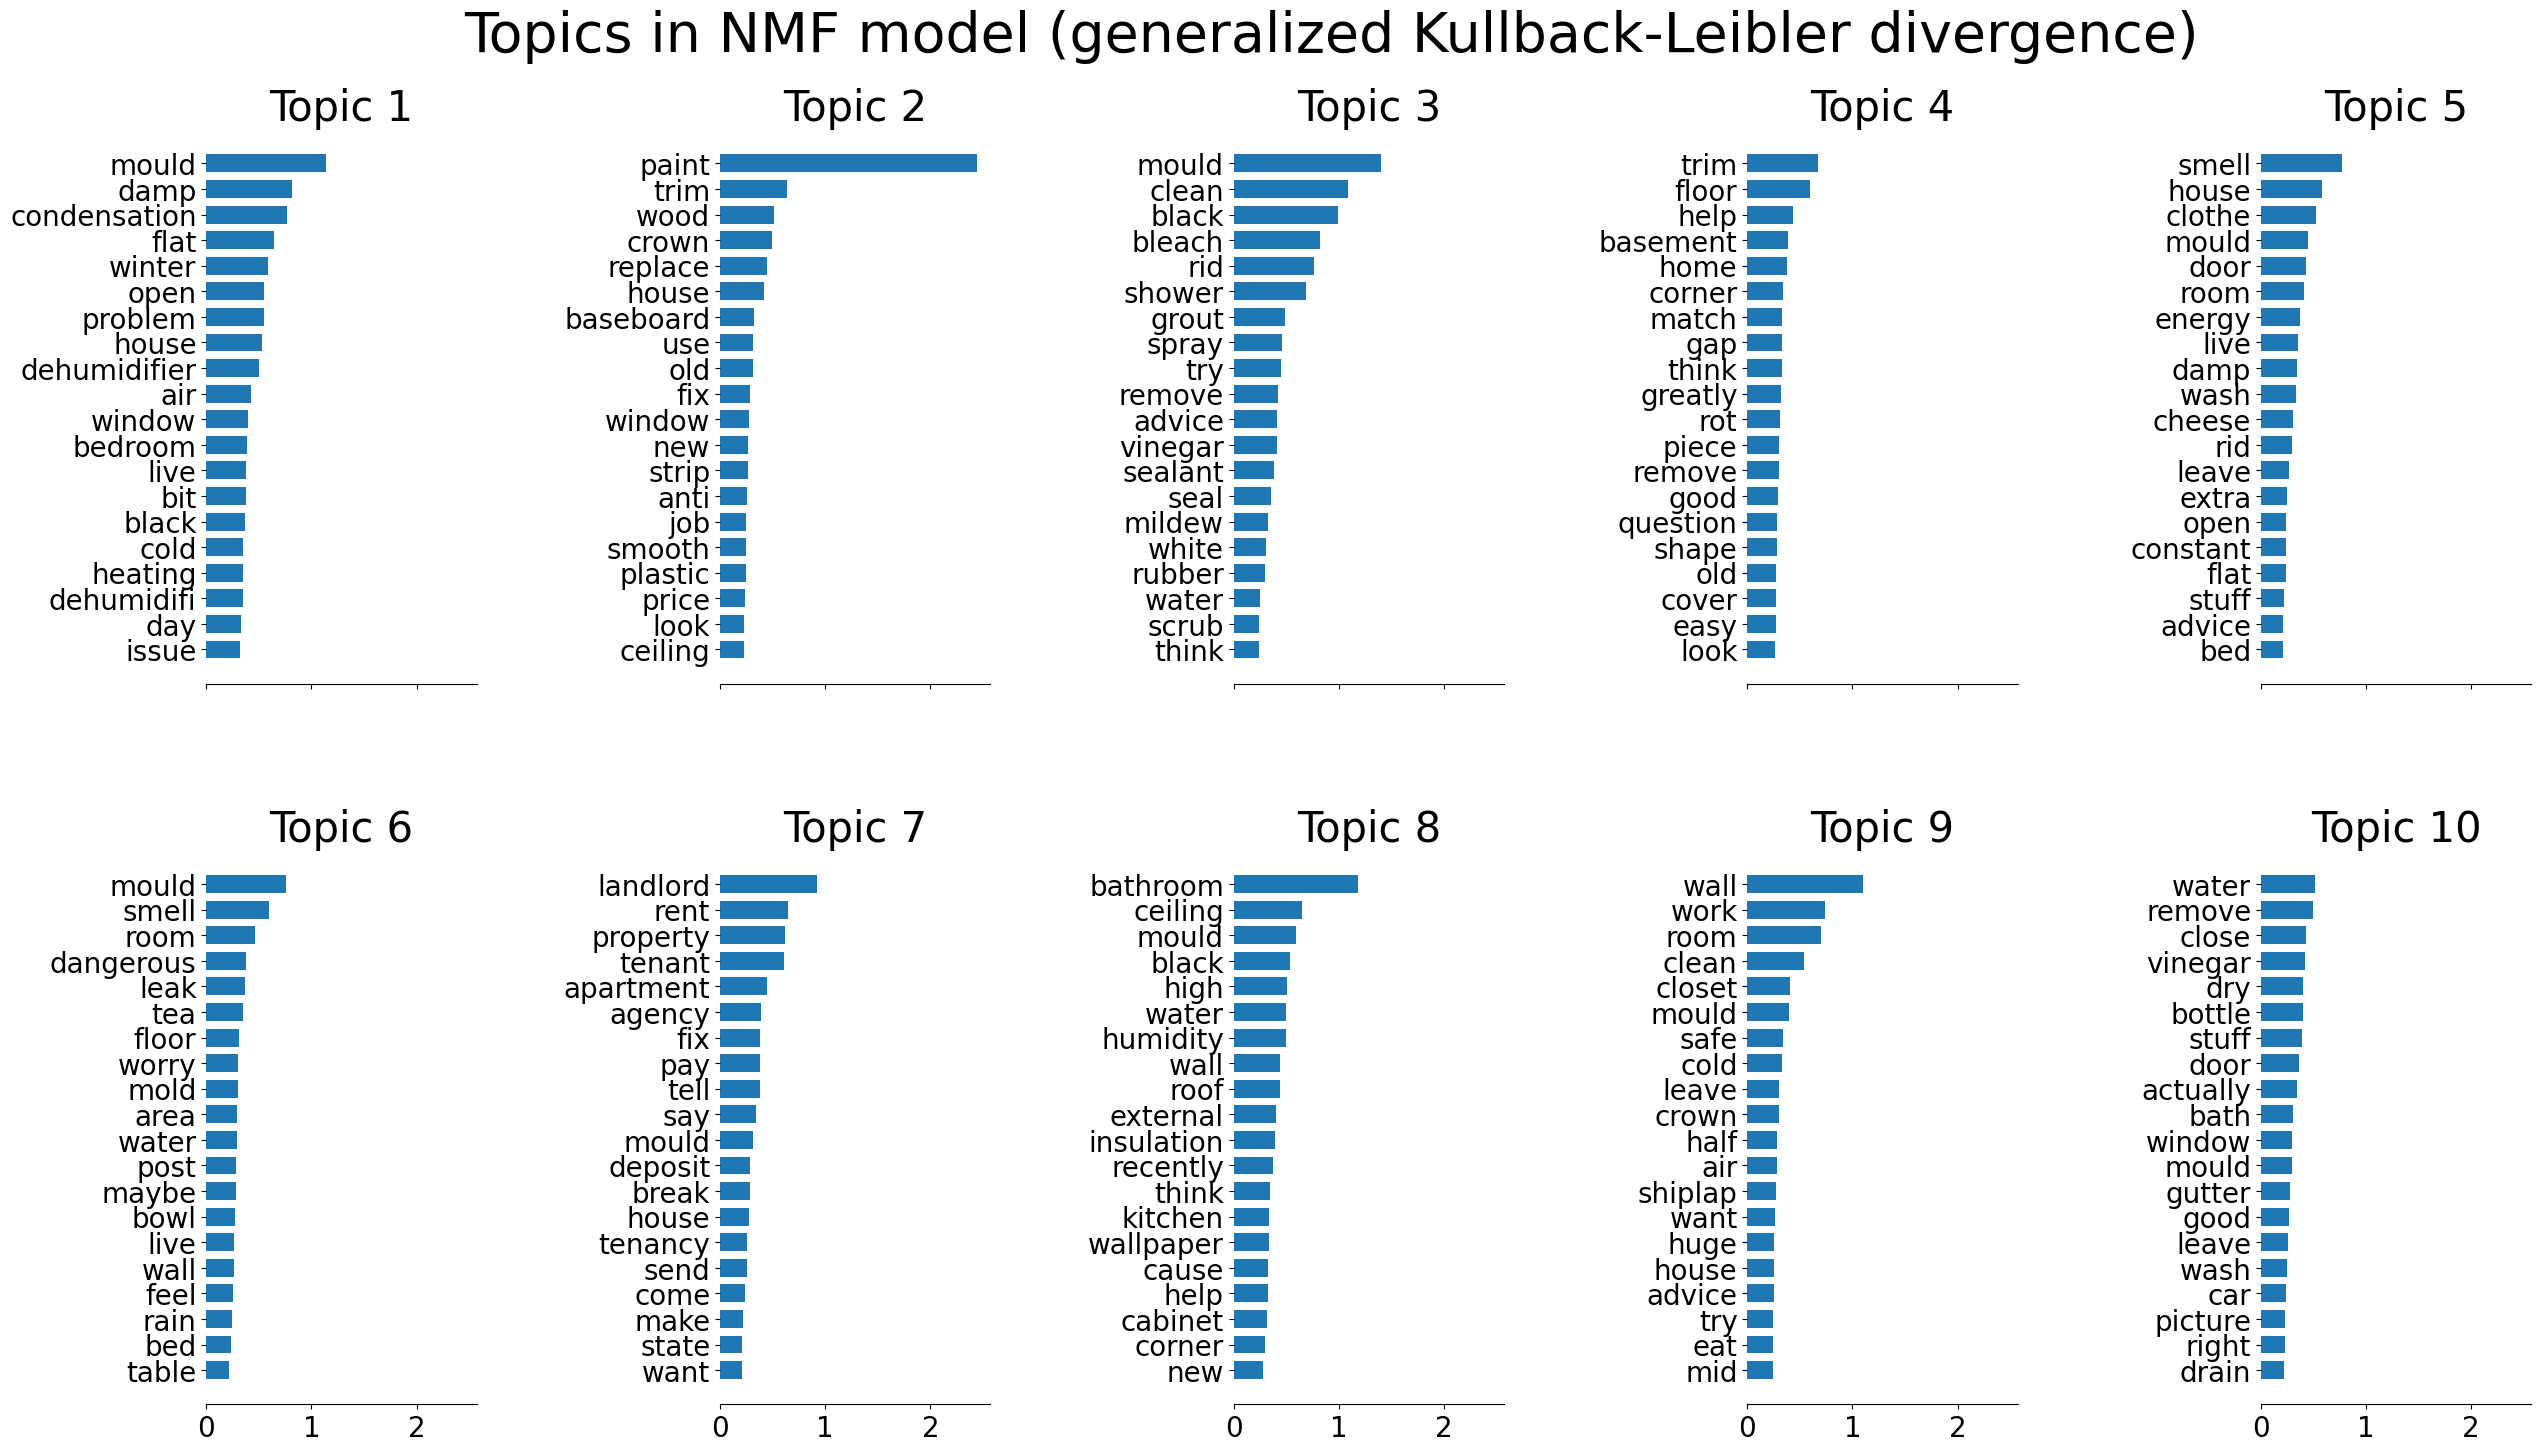

In [ ]:
# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

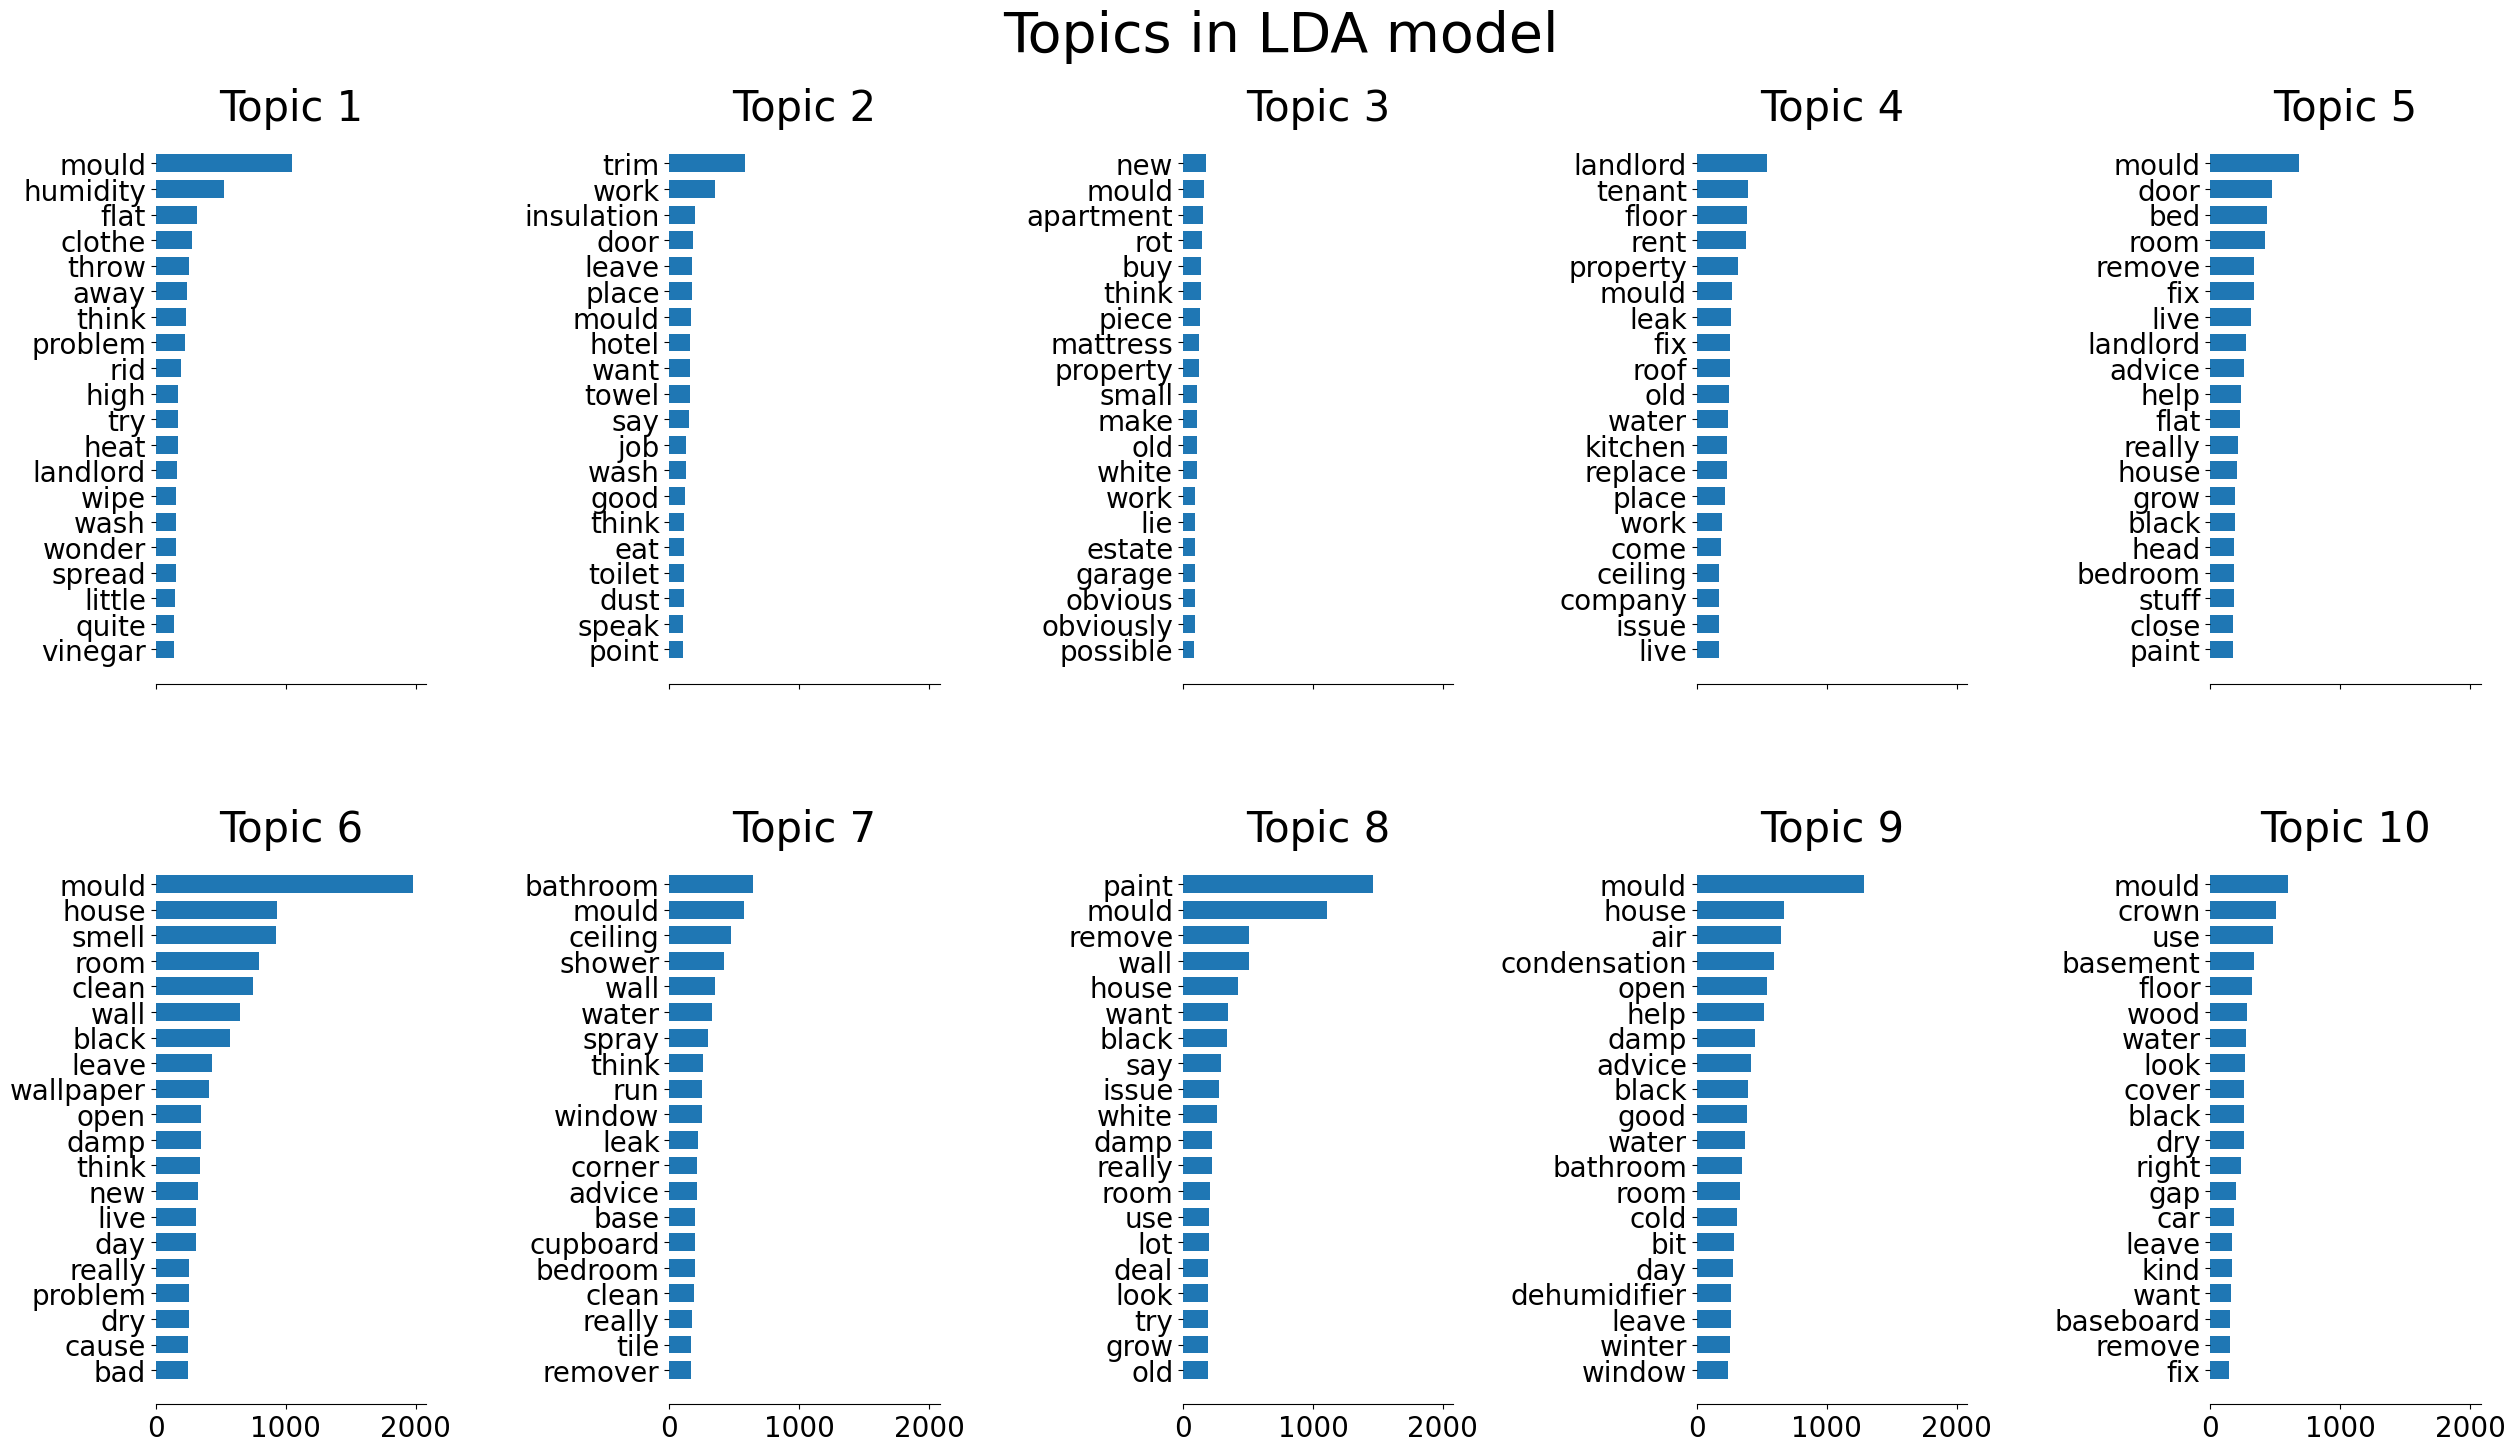

In [ ]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")